<a href="https://colab.research.google.com/github/Mtlukasik/Exploration/blob/main/unity_ds_ui_quiz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import libraries

- Import additional libraries of your choice.

Although you are expected to demonstrate understanding of ML/DS/statistics tools, a particular choice of libraries and frameworks will not affect evaluation of the solution.

In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sns
import keras
import sklearn
import hashlib
import matplotlib.pyplot as plt
import scipy.stats as stats
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import Model
from keras.layers import Input, Dense, Reshape
# Import additional libraries of your choice

# Unity Data Science quiz

At Unity, we develop deep learning models for real-time ads bidding ([OpenRTB](https://www.iab.com/guidelines/openrtb/)) at various ad
exchanges. To bid for an ad impression, we estimate the optimal bid value using predicted
install probability of campaign together with several other factors e.g. cost per install.

In this homework, your task is to **train a model to predict *install probabilities* for ad impressions included in
the test data**. In the production environment, the model predictions are used for deriving the optimial bids for available ad campaigns.  The best ad campaign will be shown to the user. Overestimation of install probabilities will lead to unnecessarily high bids and monetary losses, while underestimation of install probabilities will lead to unnecessarily low bids and loss of opportunities for Unity to win ad impressions. Therefore, it is important for the model predictions to be as accurate as possible.

## Instructions

- Complete the homework using Python and libraries of your choice.
- Follow the instructions in this notebook.
- Keep the code clean and organized.

## Evaluation

We focus our evaluation on technical proficiency, analytical skills, problem solving, creative thinking as well as ability to communicate clearly. In particular, we will evaluate:
- understanding of the problem (e.g. does a delivered solution meet the specification of the task)
- quality of discussion and brevity of the report (e.g. comments in this notebook)
- quality of EDA
- feature handling & preprocessing
- modeling approach
- model validation and evaluation

We will separately evaluate the predicted test set install probabilities (see below). Although considered as part of the evaluation, the final performance is not the key factor and shall not dominate over the above dimensions.

## Data description

- ```id```: impression id
- ```timestamp```: time of the event in UTC ```
 all installs happened  long ago this game is probably old```
- ```campaignId```: id of the advertising campaign (the game being advertised)
- ```platform```: device platform
- ```softwareVersion```: OS version of the device
- ```country```: country of user
- ```sourceGameId```: id of the publishing game (the game being played)
- ```startCount```: how many times the user has started (any) campaigns
- ```viewCount```: how many times the user has viewed (any) campaigns
- ```clickCount```: how many times the user has clicked (any) campaigns
- ```installCount```: how many times the user has installed games from this ad network
- ```lastStart```: last time the user started any campaign
- ```startCount1d```: how many times the user has started (any) campaigns within the last 24 hours
- ```startCount7d```: how many times the user has started (any) campaigns within the last 7 days
- ```connectionType```: internet connection type
- ```deviceType```: device model
- ```install```: binary indicator if install was observed (install=1) or not (install=0) after impression

## Submission

- This Jupyter notebook
- A CSV file containing the predicted install probabilities of ad impressions in the test data. The file should have the following columns:
    - ```id```: ID of ad impression in the test data
    - ```install_proba```: Predicted install probability of ad impression


# Analysis
by Mateusz Łukasik
 - start date: 2.05
 - submitted: 6.05

## Load and prepare data

In [2]:
from google.colab import drive
drive.mount('/content/drive')
train_df = pd.read_csv("/content/drive/MyDrive/training_data.csv", sep=";", parse_dates=True)
train_df = train_df[~train_df['install'].isna()]#inputing install label is classification so there is no use in it

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
train_df = train_df[~train_df['lastStart'].isna()]

In [4]:
train_df['lastStart'] = pd.to_datetime(train_df['lastStart'])

In [5]:
train_df = train_df.sort_values(by=['timestamp']).reset_index(drop=True)

In [6]:
train_df.columns

Index(['id', 'timestamp', 'campaignId', 'platform', 'softwareVersion',
       'sourceGameId', 'country', 'startCount', 'viewCount', 'clickCount',
       'installCount', 'lastStart', 'startCount1d', 'startCount7d',
       'connectionType', 'deviceType', 'install'],
      dtype='object')

In [7]:
import pandas as pd

# Ensure 'timestamp' is in datetime format
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])

# Group the DataFrame by hour
daily_groups = train_df.groupby(pd.Grouper(key='timestamp', freq='D'))

# Initialize a list to hold the sub-DataFrames
daily_dfs = []

# Iterate over each group and add the sub-DataFrame to the list
for _, group in daily_groups:
    if not group.empty:  # Check if the group is not empty
        daily_dfs.append(group)

In [8]:
[print(i.shape) for i in daily_dfs]

(315482, 17)
(313690, 17)
(306825, 17)
(281678, 17)
(232467, 17)
(225278, 17)
(189106, 17)
(201060, 17)
(214095, 17)
(211327, 17)
(223277, 17)
(257102, 17)
(272655, 17)
(219667, 17)


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [43]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

import pandas as pd
from sklearn.utils import resample

class DataPreprocessor:
    def __init__(self, numerical_columns, target_column):
        """
        Initialize the preprocessor with the list of numerical columns
        to keep and convert to floats, and the name of the target column for undersampling.
        """
        self.numerical_columns = numerical_columns
        self.target_column = target_column

    def preprocess(self, df):
        # Ensure the target column is included for processing
        columns = self.numerical_columns + [self.target_column]
        self.processed_df = df[columns].copy()

        # Convert numerical columns to float dtype
        for col in self.numerical_columns:
            self.processed_df[col] = pd.to_numeric(self.processed_df[col], errors='coerce').astype(float)

        # Perform undersampling
        self.df_majority = self.processed_df[self.processed_df[self.target_column] == 0]
        self.df_minority = self.processed_df[self.processed_df[self.target_column] != 0]
        self.len_ratio = self.df_majority.shape[0]/(self.df_majority.shape[0]+self.df_minority.shape[0])
        # Downsample the majority class
        df_majority_downsampled = resample(self.df_majority,
                                           replace=False,    # sample without replacement
                                           n_samples=len(self.df_minority),  # to match minority class size
                                           random_state=123) # reproducible results

        # Combine minority class with downsampled majority class
        balanced_df = pd.concat([self.df_minority, df_majority_downsampled])

        return balanced_df

import tensorflow as tf

class MyModel:
    def __init__(self, input_shape):
        self.model = self._build_model(input_shape)

    def _build_model(self, input_shape):
        # Define a simple Sequential model
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation='relu', input_shape=(input_shape,)),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')  # Assuming binary classification
        ])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        return model

    def fit(self, X, y, epochs=10, validation_split=0.2):
        self.model.fit(X, y, epochs=epochs, validation_split=validation_split)

    def predict(self, X):
        return self.model.predict(X)

In [50]:
class Postprocessor:
    def __init__(self, model, adjusted_threshold):
        self.model = model
        self.adjusted_threshold = adjusted_threshold

    def predict(self, X):
        # Get the model's prediction probabilities
        predictions = self.model.predict(X)

        # Apply the adjusted threshold to these probabilities to get binary predictions
        binary_predictions = (predictions > self.adjusted_threshold).astype(int)
        return binary_predictions
postprocessor = Postprocessor(my_model,preprocessor.len_ratio)

In [82]:
numerical_columns = ['startCount', 'viewCount', 'clickCount', 'installCount', 'startCount1d', 'startCount7d']
target_column = 'install'  # Assuming 'install' is your target column

# Initialize the preprocessor
preprocessor = DataPreprocessor(numerical_columns=numerical_columns, target_column=target_column)

# Preprocess your DataFrame
balanced_df = preprocessor.preprocess(daily_dfs[0])
X = balanced_df.drop(columns=[target_column])
y = balanced_df[target_column]
# Convert the target to a numeric type, if it's not already
y = pd.to_numeric(y, errors='coerce')
input_shape = X.shape[1]
# Initialize and train the model
my_model = MyModel(input_shape)
my_model.fit(X, y)

Epoch 1/10
174/174 [==============================] - 2s 4ms/step - loss: 0.8487 - accuracy: 0.5904 - val_loss: 0.8645 - val_accuracy: 0.2208
Epoch 2/10
174/174 [==============================] - 0s 3ms/step - loss: 0.6765 - accuracy: 0.6448 - val_loss: 0.8747 - val_accuracy: 0.2453
Epoch 3/10
174/174 [==============================] - 0s 3ms/step - loss: 0.6594 - accuracy: 0.6502 - val_loss: 1.0655 - val_accuracy: 0.0981
Epoch 4/10
174/174 [==============================] - 1s 3ms/step - loss: 0.6732 - accuracy: 0.6462 - val_loss: 0.8186 - val_accuracy: 0.2958
Epoch 5/10
174/174 [==============================] - 1s 3ms/step - loss: 0.6990 - accuracy: 0.6471 - val_loss: 0.8380 - val_accuracy: 0.2691
Epoch 6/10
174/174 [==============================] - 0s 3ms/step - loss: 0.6490 - accuracy: 0.6523 - val_loss: 1.2752 - val_accuracy: 0.0375
Epoch 7/10
174/174 [==============================] - 1s 4ms/step - loss: 0.6792 - accuracy: 0.6518 - val_loss: 0.8076 - val_accuracy: 0.3189
Epoch 

In [83]:
#ewaluacja
B = postprocessor.predict(preprocessor.processed_df.drop(columns=[target_column]))
sum(B)/len(B)

9859/9859 [==============================] - 17s 2ms/step


array([0.029783])

In [84]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
for i in enumerate(daily_dfs):
  if i[0]>0.0:
    print(i[0])
    preprocessor_new = DataPreprocessor(numerical_columns=numerical_columns, target_column=target_column)
    preprocessor_new.preprocess(daily_dfs[i[0]])
    predictions_on_new_day = postprocessor.predict(preprocessor_new.processed_df.drop(columns=[target_column]))
    # Calculate metrics
    accuracy_pre = accuracy_score(preprocessor_new.processed_df[target_column], predictions_on_new_day)
    precision_pre = precision_score(preprocessor_new.processed_df[target_column], predictions_on_new_day)
    recall_pre = recall_score(preprocessor_new.processed_df[target_column], predictions_on_new_day)
    f1_pre = f1_score(preprocessor_new.processed_df[target_column], predictions_on_new_day)
    roc_auc_pre = roc_auc_score(preprocessor_new.processed_df[target_column], predictions_on_new_day)

    print(f"Accuracy: {accuracy_pre}")
    print(f"Precision: {precision_pre}")
    print(f"Recall: {recall_pre}")
    print(f"F1 Score: {f1_pre}")
    print(f"ROC-AUC Score: {roc_auc_pre}")
    predictions_on_new_day_flat = predictions_on_new_day.flatten()
    is_positive_prediction = predictions_on_new_day_flat.astype(bool)
    selected_rows = preprocessor_new.processed_df[is_positive_prediction]
    train_df_updated = pd.concat([preprocessor.processed_df, selected_rows])
    print(f"New length for ith:{i[0]} iteration {train_df_updated.shape} now proceeding to train model again:")
    numerical_columns = ['startCount', 'viewCount', 'clickCount', 'installCount', 'startCount1d', 'startCount7d']
    target_column = 'install'  # Assuming 'install' is your target column

    # Initialize the preprocessor
    preprocessor = DataPreprocessor(numerical_columns=numerical_columns, target_column=target_column)

    # Preprocess your DataFrame
    balanced_df = preprocessor.preprocess(train_df_updated)
    X = balanced_df.drop(columns=[target_column])
    y = balanced_df[target_column]
    # Convert the target to a numeric type, if it's not already
    y = pd.to_numeric(y, errors='coerce')
    input_shape = X.shape[1]
    # Initialize and train the model
    my_model = MyModel(input_shape)
    my_model.fit(X, y)

1
9803/9803 [==============================] - 15s 2ms/step
Accuracy: 0.9583123465842074
Precision: 0.006911718504555451
Recall: 0.018032786885245903
F1 Score: 0.0099931864637747
ROC-AUC Score: 0.49372271218597036
New length for ith:1 iteration (325031, 7) now proceeding to train model again:
Epoch 1/10
177/177 [==============================] - 2s 3ms/step - loss: 0.8619 - accuracy: 0.6068 - val_loss: 1.1860 - val_accuracy: 0.1211
Epoch 2/10
177/177 [==============================] - 0s 3ms/step - loss: 0.7145 - accuracy: 0.6410 - val_loss: 0.7533 - val_accuracy: 0.3562
Epoch 3/10
177/177 [==============================] - 0s 2ms/step - loss: 0.7558 - accuracy: 0.6343 - val_loss: 0.6732 - val_accuracy: 0.4377
Epoch 4/10
177/177 [==============================] - 0s 3ms/step - loss: 0.7235 - accuracy: 0.6481 - val_loss: 0.8194 - val_accuracy: 0.3237
Epoch 5/10
177/177 [==============================] - 0s 2ms/step - loss: 0.6677 - accuracy: 0.6490 - val_loss: 0.6460 - val_accuracy: 0.4

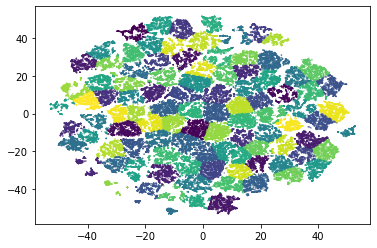

In [ ]:
plt.scatter(SNFITSNE[:,0],SNFITSNE[:,1],s=0.1,c=KMEANS_PRED)

#pca_kmeans_feature
will it be better than hashes for all 5 nominal features?

In [ ]:
feature_input = pd.concat([train_df['country'].apply(lambda x:f(countries,x)),
           train_df['deviceType'].apply(lambda x:f(deviceType,x)),
           train_df['softwareVersion'].apply(lambda x:f(softwareVersion,x)),
           train_df['campaignId'].apply(lambda x:f(campaignId,x)),
           train_df['sourceGameId'].apply(lambda x:f(sourceGameId,x))],axis=1)

In [ ]:
kmeans = KMeans(n_clusters=100)
kmeans.fit(SNFIPCA) # we train on 10 dimentional PCA output instead of TSNE

In [ ]:
feature_input

In [ ]:
s = np.matrix([[k for i in j for k in i] for j in feature_input.values])
sss = ss.transform(s)

/usr/local/lib/python3.7/dist-packages/numpy/matrixlib/defmatrix.py:145: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = N.array(data, dtype=dtype, copy=copy)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


In [ ]:
train_df['pca_kmeans_feature'] = kmeans.predict(pca.transform(sss))

In [ ]:
# Example of binarization - color red from previous images =0 , blue = 1
train_df['country_hash'] = train_df['country'].apply(lambda x: abs(hash(x)%10))
train_df['softwareVersion_hash'] = train_df['softwareVersion'].apply(lambda x: abs(hash(x)%10))
train_df['deviceType_hash'] = train_df['deviceType'].apply(lambda x: abs(hash(x)%10))

# Example of dealing with categorical columns with hash trick
train_df['campaignId_hash'] = train_df['campaignId'].apply(lambda x: abs(hash(x)%99))
train_df['sourceGameId_hash'] = train_df['sourceGameId'].apply(lambda x: abs(hash(x)%99))

- We have no NaN values left

In [ ]:
train_df[train_df.isna().any(axis=1)]

,campaignId,clickCount,country,deviceType,install,installCount,softwareVersion,sourceGameId,startCount,startCount1d,...,connectionType_none,connectionType_wifi,platform_android,platform_ios,pca_kmeans_feature,country_hash,softwareVersion_hash,deviceType_hash,campaignId_hash,sourceGameId_hash


In [ ]:
train_df.to_csv('/content/drive/MyDrive/training_data_preprocessed.csv')

In [ ]:
train_df

,Unnamed: 0,campaignId,clickCount,country,deviceType,install,installCount,softwareVersion,sourceGameId,startCount,...,connectionType_none,connectionType_wifi,platform_android,platform_ios,pca_kmeans_feature,country_hash,softwareVersion_hash,deviceType_hash,campaignId_hash,sourceGameId_hash
0,0,59687f0d896a6b0e5ce6ea15,0,US,"iPhone8,2",0,2,11.4.1,1373094,25,...,0,0,0,1,79,9,9,1,69,63
1,1,59687f0d896a6b0e5ce6ea15,2,US,"iPhone9,1",0,0,12.1,2739989,10,...,0,0,0,1,79,9,9,7,69,65
2,2,59687f0d896a6b0e5ce6ea15,0,US,"iPhone7,1",0,0,12.1.2,1373094,27,...,0,0,0,1,79,9,3,1,69,63
3,3,59687f0d896a6b0e5ce6ea15,2,US,"iPhone7,2",0,0,12.1.2,1217749,15,...,0,1,0,1,79,9,3,4,69,49
4,4,59687f0d896a6b0e5ce6ea15,0,US,"iPhone8,1",0,0,12.0.1,1373094,20,...,0,0,0,1,79,9,2,2,69,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3738758,3738758,5c3f8ddfacba384ae5d5199f,0,US,"iPad5,3",0,0,12.1.1,1100513,20,...,0,1,0,1,59,9,6,6,31,29
3738759,3738759,5c3f8ddfacba384ae5d5199f,0,US,"iPhone9,4",0,0,12.1.2,69149,1,...,0,1,0,1,79,9,3,4,31,47
3738760,3738760,5c3f8ddfacba384ae5d5199f,0,US,"iPhone8,1",0,0,12.1.2,69149,8,...,0,1,0,1,79,9,3,2,31,47
3738761,3738761,5c3f8ddfacba384ae5d5199f,0,US,"iPhone10,3",0,0,12.1.2,69149,64,...,0,1,0,1,51,9,3,7,31,47


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
train_df= pd.read_csv('/content/drive/MyDrive/training_data_preprocessed.csv')
train_df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Unnamed: 0,campaignId,clickCount,country,deviceType,install,installCount,softwareVersion,sourceGameId,startCount,...,connectionType_none,connectionType_wifi,platform_android,platform_ios,pca_kmeans_feature,country_hash,softwareVersion_hash,deviceType_hash,campaignId_hash,sourceGameId_hash
0,0,59687f0d896a6b0e5ce6ea15,0,US,"iPhone8,2",0,2,11.4.1,1373094,25,...,0,0,0,1,79,9,9,1,69,63
1,1,59687f0d896a6b0e5ce6ea15,2,US,"iPhone9,1",0,0,12.1,2739989,10,...,0,0,0,1,79,9,9,7,69,65
2,2,59687f0d896a6b0e5ce6ea15,0,US,"iPhone7,1",0,0,12.1.2,1373094,27,...,0,0,0,1,79,9,3,1,69,63
3,3,59687f0d896a6b0e5ce6ea15,2,US,"iPhone7,2",0,0,12.1.2,1217749,15,...,0,1,0,1,79,9,3,4,69,49
4,4,59687f0d896a6b0e5ce6ea15,0,US,"iPhone8,1",0,0,12.0.1,1373094,20,...,0,0,0,1,79,9,2,2,69,63


In [ ]:
train_df.columns

Index(['Unnamed: 0', 'campaignId', 'clickCount', 'country', 'deviceType',
       'install', 'installCount', 'softwareVersion', 'sourceGameId',
       'startCount', 'startCount1d', 'startCount7d', 'time_passed',
       'viewCount', 'time_nan', 'connectionType_cellular',
       'connectionType_none', 'connectionType_wifi', 'platform_android',
       'platform_ios', 'pca_kmeans_feature', 'country_hash',
       'softwareVersion_hash', 'deviceType_hash', 'campaignId_hash',
       'sourceGameId_hash'],
      dtype='object')

In [ ]:
train_df_bins

,campaignId_hash,clickCount,connectionType_cellular,connectionType_none,connectionType_wifi,country_hash,deviceType_hash,install,installCount,pca_kmeans_feature,platform_android,platform_ios,softwareVersion_hash,sourceGameId_hash,startCount,startCount1d,startCount7d,time_nan,time_passed,viewCount
0,69,0,1,0,0,9,1,0,2,79,0,1,9,63,25,1,8,0,26.507500,24
1,69,2,1,0,0,9,7,0,0,79,0,1,9,65,10,1,4,0,44.379167,9
2,69,0,1,0,0,9,1,0,0,79,0,1,3,63,27,1,2,0,49.021389,26
3,69,2,0,0,1,9,4,0,0,79,0,1,3,49,15,3,14,0,19.198611,14
4,69,0,1,0,0,9,2,0,0,79,0,1,2,63,20,13,18,0,0.013333,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3738758,31,0,0,0,1,9,6,0,0,59,0,1,6,29,20,1,7,0,25.718333,19
3738759,31,0,0,0,1,9,4,0,0,79,0,1,3,47,1,1,1,1,0.000000,0
3738760,31,0,0,0,1,9,2,0,0,79,0,1,3,47,8,8,8,0,1.813333,7
3738761,31,0,0,0,1,9,7,0,0,51,0,1,3,47,64,2,17,0,1.379444,61


## Game2Vec embedding experimentation
I found some implementation of word 2 vec and I give it a try here to represent simmilarity of game being played to game being advertised. This resembles recommendation system output.

In [ ]:
temp_install = train_df[train_df['install']==1].groupby(by=['campaignId','sourceGameId']).size().sort_values(ascending=False)
temp_not_install = train_df[train_df['install']==0].groupby(by=['campaignId','sourceGameId']).size().sort_values(ascending=False)
temp_install

campaignId                sourceGameId
5b9d3bb056c7fc3e0e4c0e3c  1483109         73
5bd2ccefc9c2110ad461c1b3  2633648         71
5b9d371252bb0e3d8ca5c69f  2643690         65
5bd2ccefc9c2110ad461c1b3  2762289         64
5b9d371252bb0e3d8ca5c69f  1373044         61
                                          ..
5bd868b72efaa303b85e881c  2579215          1
                          63367            1
5bd8649bafef850034aad875  2645040          1
                          1796504          1
5c45c1c017d4251a9487668a  2952621          1
Length: 32099, dtype: int64

In [ ]:
temp_not_install

campaignId                sourceGameId
5c385d02ee4549000d8b9ddd  1711292         3934
                          19186           3524
5afbea849f23a400284f2619  1711292         2625
5c385d02ee4549000d8b9ddd  19790           2570
5c1b87728fe2396cc2ab049f  1483109         2499
                                          ... 
5be2e96ad783dc0ee412a5c7  2750566            1
                          2763850            1
                          2778542            1
                          2810022            1
5c00751a2788ec3b966d3019  2717417            1
Length: 1112370, dtype: int64

In [ ]:
scalable_columns = ['clickCount','installCount','startCount', 'startCount1d', 'startCount7d', 'time_passed',
       'viewCount', 'time_nan', 'connectionType_cellular',
       'connectionType_none', 'connectionType_wifi', 'platform_android',
       'platform_ios',  'country_hash',
       'softwareVersion_hash', 'deviceType_hash']

In [ ]:
n=0
dict_o_games={}
for i in train_df['campaignId']:
  dict_o_games[n]=i
  n+=1
for i in train_df['sourceGameId']:
  dict_o_games[n]=i
  n+=1
reversed_dict_o_games = {dict_o_games[i]:i for i in dict_o_games.keys()}

input_target = Input((1,))
input_context = Input((1,))

embedding = Embedding(n, 4, input_length=1, name='embedding')

target = embedding(input_target)
target = Reshape((4, 1))(target)

context = embedding(input_context)
context = Reshape((4, 1))(context)


# now perform the dot product operation to get a similarity measure
dot_product = dot([target, context], axes=1, normalize=False) # number

x = Reshape((1,))(dot_product)
# add the sigmoid output layer
output = Dense(1, activation='sigmoid')(x)
# create the primary training model
model = Model([input_target, input_context], output)
model.compile(loss='binary_crossentropy', optimizer='rmsprop')
epochs = 2000 # this could be run 200000 times but due to situation this is just a demonstration
arr_1 = np.zeros((1,))
arr_2 = np.zeros((1,))
arr_4 = np.zeros((1,))
for cnt in range(epochs):
  for i,row in analysis.X_train.iterrows():
    arr_1[0,] = tf.stack(reversed_dict_o_games[row['campaignId']])
    arr_2[0,] = tf.stack(reversed_dict_o_games[row['sourceGameId']])
    arr_4[0,] = analysis.y_train[i]
    loss = model.fit( [arr_1,arr_2], tf.stack(arr_4), verbose=0)
    break
  if cnt % 100 == 0:
      print("Iteration {}, loss={}".format(cnt, loss))

Iteration 0, loss=<keras.callbacks.History object at 0x7fa308f12a10>
Iteration 100, loss=<keras.callbacks.History object at 0x7fa30925fad0>
Iteration 200, loss=<keras.callbacks.History object at 0x7fa2fcc8cb50>
Iteration 300, loss=<keras.callbacks.History object at 0x7fa2fd483f90>
Iteration 400, loss=<keras.callbacks.History object at 0x7fa2fe1cac50>
Iteration 500, loss=<keras.callbacks.History object at 0x7fa2f900a5d0>
Iteration 600, loss=<keras.callbacks.History object at 0x7fa304228990>
Iteration 700, loss=<keras.callbacks.History object at 0x7fa2ff7ff910>
Iteration 800, loss=<keras.callbacks.History object at 0x7fa306dbe6d0>
Iteration 900, loss=<keras.callbacks.History object at 0x7fa2fc2daf50>
Iteration 1000, loss=<keras.callbacks.History object at 0x7fa31067c7d0>
Iteration 1100, loss=<keras.callbacks.History object at 0x7fa32cf30750>
Iteration 1200, loss=<keras.callbacks.History object at 0x7fa313872050>
Iteration 1300, loss=<keras.callbacks.History object at 0x7fa3157fc3d0>
Iter

## Checking if we can use this embedding
I see that it learned something but it would take too long to utilze it now

In [ ]:
games_simmilarity = []
n=0
for i,row in analysis.X_train.iterrows():
  arr_1[0,] = tf.stack(reversed_dict_o_games[row['campaignId']])
  arr_2[0,] = tf.stack(reversed_dict_o_games[row['sourceGameId']])
  arr_4[0,] = analysis.y_train[i]
  n+=1
  if n%1000 == 0:
    print(n)
    %timeit (model.predict( [arr_1,arr_2], verbose=0)[0][0])
    print(model.predict( [arr_1,arr_2], verbose=0)[0][0])
    games_simmilarity.append(a)
  if n==5000:
    break

1000
10 loops, best of 5: 55.2 ms per loop
0.22317702
2000
10 loops, best of 5: 54.3 ms per loop
0.22253451
3000
10 loops, best of 5: 54.5 ms per loop
0.22256461
4000
10 loops, best of 5: 54.3 ms per loop
0.22302973
5000
10 loops, best of 5: 51.9 ms per loop
0.22323632


## TODO:
 - Compare this with pca_kmeans_feature embedding and with probability of install/noinstall
 - Add ```User Vector ```as third input to neural network and train them together.
 - Run this substantialy longer
 - Maybe forcing this to reconstruct ```VAE``` could create a good model that could also fill in the NaN values

Scaling the data

In [ ]:
train_df_bins =train_df[train_df.columns.difference(['Unnamed: 0','campaignId','country','deviceType','sourceGameId','softwareVersion'])]

In [ ]:
train_df

,Unnamed: 0,campaignId,clickCount,country,deviceType,install,installCount,softwareVersion,sourceGameId,startCount,...,connectionType_none,connectionType_wifi,platform_android,platform_ios,pca_kmeans_feature,country_hash,softwareVersion_hash,deviceType_hash,campaignId_hash,sourceGameId_hash
0,0,59687f0d896a6b0e5ce6ea15,0,US,"iPhone8,2",0,2,11.4.1,1373094,25,...,0,0,0,1,79,9,9,1,69,63
1,1,59687f0d896a6b0e5ce6ea15,2,US,"iPhone9,1",0,0,12.1,2739989,10,...,0,0,0,1,79,9,9,7,69,65
2,2,59687f0d896a6b0e5ce6ea15,0,US,"iPhone7,1",0,0,12.1.2,1373094,27,...,0,0,0,1,79,9,3,1,69,63
3,3,59687f0d896a6b0e5ce6ea15,2,US,"iPhone7,2",0,0,12.1.2,1217749,15,...,0,1,0,1,79,9,3,4,69,49
4,4,59687f0d896a6b0e5ce6ea15,0,US,"iPhone8,1",0,0,12.0.1,1373094,20,...,0,0,0,1,79,9,2,2,69,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3738758,3738758,5c3f8ddfacba384ae5d5199f,0,US,"iPad5,3",0,0,12.1.1,1100513,20,...,0,1,0,1,59,9,6,6,31,29
3738759,3738759,5c3f8ddfacba384ae5d5199f,0,US,"iPhone9,4",0,0,12.1.2,69149,1,...,0,1,0,1,79,9,3,4,31,47
3738760,3738760,5c3f8ddfacba384ae5d5199f,0,US,"iPhone8,1",0,0,12.1.2,69149,8,...,0,1,0,1,79,9,3,2,31,47
3738761,3738761,5c3f8ddfacba384ae5d5199f,0,US,"iPhone10,3",0,0,12.1.2,69149,64,...,0,1,0,1,51,9,3,7,31,47


In [ ]:
"""from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_df_bins[scalable_columns] = pd.DataFrame(scaler.fit_transform(train_df_bins[scalable_columns]),columns=scalable_columns)"""

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [ ]:
analysis = Analysis(train_df_bins,'install',test_split=0.01)# this is the same instance since random_state is default

# Inbalanced dataset problem
- ```OverSampling```
- ```UnderSampling``` - tried here<br>
- ```Long-tail learning via logit adjustment```

In [ ]:
X_u,y_u = RandomUnderSampler('majority').fit_resample(analysis.X_train,analysis.y_train)
X_va_u,y_va_u = RandomUnderSampler('majority').fit_resample(analysis.X_val,analysis.y_val)

/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:591: FutureWarning: Pass sampling_strategy=majority as keyword args. From version 0.9 passing these as positional arguments will result in an error
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:591: FutureWarning: Pass sampling_strategy=majority as keyword args. From version 0.9 passing these as positional arguments will result in an error
  FutureWarning,


#Baseline - highly inbalanced dataset
- highly inbalance set:<br>
  -play with sampling + logistic/svm <b>I am choosing this option</b><br>
  or<br>
  -specific algorithm for anomaly detection<br>

In [ ]:
class ResultsInstance:
  """
  This class represents instance of running classifier up against specific dataset.
  Holds classifier so we can always check it
  Holds metrics
  """
  def __init__(self,clf,params=None):
    self.params = params
    if 'classifier' in params:
      self.classifier = clf(self.params['classifier'])
    else:
      self.classifier = clf()

  def apply(self,X_train,y_train,X_val,y_val):
    self.classifier.fit(X_train,y_train)
    self.confusion = metrics.confusion_matrix(y_val, self.classifier.predict(X_val) )
    return self,{"score":self.classifier.score(X_val,y_val),"TN":self.confusion[0,0],"FP":self.confusion[0,1],"FN":self.confusion[1,0],"TP":self.confusion[1,1]}

In [ ]:
analysis('downsampler_majority',{'logreg':LogisticRegression},params={'sampler':'majority'},X_train=X_u,X_val=X_va_u,y_train=y_u,y_val=y_va_u)

logreg
done


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
analysis.results_dictionary

{'downsampler_majority_logreg': (<__main__.ResultsInstance at 0x7fa301c5c7d0>,
  {'FN': 1394,
   'FP': 2152,
   'TN': 2233,
   'TP': 2991,
   'score': 0.595667046750285})}

In [ ]:
from sklearn.tree import DecisionTreeClassifier
#Decision tree acts bad with one hot variables
analysis('downsampler_majority',{'decision_tree':DecisionTreeClassifier},params={'sampler':'majority'},X_train=X_u,X_val=X_va_u,y_train=y_u,y_val=y_va_u)

decision_tree
done


In [ ]:
analysis.results_dictionary

{'downsampler_majority_decision_tree': (<__main__.ResultsInstance at 0x7fa2fa8555d0>,
  {'FN': 1874,
   'FP': 1876,
   'TN': 2509,
   'TP': 2511,
   'score': 0.572405929304447}),
 'downsampler_majority_logreg': (<__main__.ResultsInstance at 0x7fa301c5c7d0>,
  {'FN': 1394,
   'FP': 2152,
   'TN': 2233,
   'TP': 2991,
   'score': 0.595667046750285})}

## Task 2: Train a model

- Discuss your model design
- Perform features preprocessing if necessary
- Create and train a model of your choice. We suggest using a neural network, but other options can also be used.

This Neural network is a main architecture. It's important to notice this is a count data, but experiments showed it's better not to scale.
We try regularization vs no regularization.


In [ ]:
#WITHOUT HASH TRICK
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

class CustomNN:
  def __init__(self,params):
    self.params = params
    self.model = Sequential()
    self.model.add(Dense(50, input_dim=params['input_shape'],activation='relu'))
    self.model.add(Dense(50, input_dim=50,
    activation='relu'))
    self.model.add(Dense(12, input_dim=12,activation='relu'))

    self.model.add(Dense(5, activation='relu'))
    self.model.add(Dense(1, activation='sigmoid'))
    # Compile model
    self.model.compile(loss='binary_crossentropy', optimizer='adam',
              metrics=[keras.metrics.BinaryAccuracy(),
                       keras.metrics.TruePositives()])
  # Fit the model
  def fit(self,X,y):
      self.model.fit(X, y, epochs=70, batch_size=500, verbose=2)

  def predict(self,X):
    return np.round(self.model.predict(X))

  def score(self,X,y):
    return self.model.evaluate(X, y, verbose=0)



class CustomNNwRegularization:
  def __init__(self,params):
    self.params = params
    self.model = Sequential()
    self.model.add(Dense(50, input_dim=params['input_shape'],activation='relu', kernel_regularizer='l1_l2'))
    self.model.add(Dense(50, input_dim=50,
    activation='relu', kernel_regularizer='l1_l2'))
    self.model.add(Dense(12, input_dim=12,activation='relu'))

    self.model.add(Dense(5, activation='relu'))
    self.model.add(Dense(1, activation='sigmoid'))
    # Compile model
    self.model.compile(loss='binary_crossentropy', optimizer='adam',
              metrics=[keras.metrics.BinaryAccuracy(),
                       keras.metrics.TruePositives()])
  # Fit the model
  def fit(self,X,y):
      self.model.fit(X, y, epochs=200, batch_size=500, verbose=2)

  def predict(self,X):
    return np.round(self.model.predict(X))

  def score(self,X,y):
    return self.model.evaluate(X, y, verbose=0)

#M = CustomNN()
#M.fit(X,y)

In [ ]:
analysis('downsampler_majority_no_pca_feature',{'logreg':LogisticRegression},params={'sampler':'majority'},X_train=X_u[X_u.columns.difference(['pca_kmeans_feature'])],X_val=X_va_u[X_u.columns.difference(['pca_kmeans_feature'])],y_train=y_u,y_val=y_va_u)

logreg
done


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
analysis('downsampler_majority',{'NN':CustomNNwRegularization},params={'sampler':'majority','classifier':{'input_shape':len(X_u.columns)}},X_train=X_u,X_val=X_va_u,y_train=y_u,y_val=y_va_u)
analysis('downsampler_majority_no_pca_feature',{'NN':CustomNNwRegularization},params={'sampler':'majority','classifier':{'input_shape':len(X_u.columns)-1}},X_train=X_u[X_u.columns.difference(['pca_kmeans_feature'])],X_val=X_va_u[X_u.columns.difference(['pca_kmeans_feature'])],y_train=y_u,y_val=y_va_u)
hash_cols = list(X_u.columns[[i.endswith('hash') for i in X_u.columns]])
analysis('downsampler_majority_no_hash_cols_feature',{'NN':CustomNNwRegularization},params={'sampler':'majority','classifier':{'input_shape':len(X_u.columns.difference(hash_cols))}},X_train=X_u[X_u.columns.difference(hash_cols)],X_val=X_va_u[X_u.columns.difference(hash_cols)],y_train=y_u,y_val=y_va_u)
analysis('downsampler_majority',{'NN':CustomNN},params={'sampler':'majority','classifier':{'input_shape':len(X_u.columns)}},X_train=X_u,X_val=X_va_u,y_train=y_u,y_val=y_va_u)
analysis('downsampler_majority_no_pca_feature',{'NN':CustomNN},params={'sampler':'majority','classifier':{'input_shape':len(X_u.columns)-1}},X_train=X_u[X_u.columns.difference(['pca_kmeans_feature'])],X_val=X_va_u[X_u.columns.difference(['pca_kmeans_feature'])],y_train=y_u,y_val=y_va_u)
hash_cols = list(X_u.columns[[i.endswith('hash') for i in X_u.columns]])
analysis('downsampler_majority_no_hash_cols_feature',{'NN':CustomNN},params={'sampler':'majority','classifier':{'input_shape':len(X_u.columns.difference(hash_cols))}},X_train=X_u[X_u.columns.difference(hash_cols)],X_val=X_va_u[X_u.columns.difference(hash_cols)],y_train=y_u,y_val=y_va_u)


NN
Epoch 1/200
160/160 - 1s - loss: 4.3743 - binary_accuracy: 0.5249 - true_positives_14: 10648.0000 - 1s/epoch - 9ms/step
Epoch 2/200
160/160 - 1s - loss: 2.0743 - binary_accuracy: 0.5598 - true_positives_14: 24800.0000 - 576ms/epoch - 4ms/step
Epoch 3/200
160/160 - 1s - loss: 1.2909 - binary_accuracy: 0.5654 - true_positives_14: 29062.0000 - 600ms/epoch - 4ms/step
Epoch 4/200
160/160 - 1s - loss: 0.9815 - binary_accuracy: 0.5642 - true_positives_14: 29644.0000 - 542ms/epoch - 3ms/step
Epoch 5/200
160/160 - 0s - loss: 0.8344 - binary_accuracy: 0.5645 - true_positives_14: 28868.0000 - 492ms/epoch - 3ms/step
Epoch 6/200
160/160 - 1s - loss: 0.7602 - binary_accuracy: 0.5640 - true_positives_14: 29404.0000 - 516ms/epoch - 3ms/step
Epoch 7/200
160/160 - 0s - loss: 0.7256 - binary_accuracy: 0.5630 - true_positives_14: 30040.0000 - 491ms/epoch - 3ms/step
Epoch 8/200
160/160 - 1s - loss: 0.7067 - binary_accuracy: 0.5637 - true_positives_14: 30378.0000 - 513ms/epoch - 3ms/step
Epoch 9/200
160/

In [ ]:
analysis.results_dictionary

{'downsampler_majority_NN': (<__main__.ResultsInstance at 0x7fa310886310>,
  {'FN': 1419,
   'FP': 2043,
   'TN': 2342,
   'TP': 2966,
   'score': [0.6558753848075867, 0.6052451729774475, 2966.0]}),
 'downsampler_majority_decision_tree': (<__main__.ResultsInstance at 0x7fa2fa8555d0>,
  {'FN': 1874,
   'FP': 1876,
   'TN': 2509,
   'TP': 2511,
   'score': 0.572405929304447}),
 'downsampler_majority_logreg': (<__main__.ResultsInstance at 0x7fa2958eb5d0>,
  {'FN': 1484,
   'FP': 2078,
   'TN': 2307,
   'TP': 2901,
   'score': 0.5938426453819841}),
 'downsampler_majority_no_hash_cols_feature_NN': (<__main__.ResultsInstance at 0x7fa30f166c50>,
  {'FN': 1739,
   'FP': 1711,
   'TN': 2674,
   'TP': 2646,
   'score': [0.6522365212440491, 0.6066134572029114, 2646.0]}),
 'downsampler_majority_no_pca_feature_NN': (<__main__.ResultsInstance at 0x7fa30c361990>,
  {'FN': 1497,
   'FP': 1956,
   'TN': 2429,
   'TP': 2888,
   'score': [0.6529269218444824, 0.6062713861465454, 2888.0]}),
 'downsampler_m

#All those models are weak

- This seams that this heuristic embedding did as much as simple hash trick.
- Scaled data yieldeed worse results
#TODO

- Use ensemble of those models, would be better use of time then information extraction via encodings
- Extract softwareversion / device info via regex
- Additional feature via different Encoders
- Play around with different architectures of Neural Networks
- Other mechanisms for Unbalanced dataset


As we see the feature experiment showed the Hashing trick was not better then

## Task 3: Model validation, evaluation, tuning and discussion

- Validate your model performance using appropriate approaches
- Discuss your model performance and tune it if necessary
- Discuss potential improvements

In [ ]:
train_df[['campaignId','sourceGameId']].values

array([['59687f0d896a6b0e5ce6ea15', 1373094],
       ['59687f0d896a6b0e5ce6ea15', 2739989],
       ['59687f0d896a6b0e5ce6ea15', 1373094],
       ...,
       ['5c3f8ddfacba384ae5d5199f', 69149],
       ['5c3f8ddfacba384ae5d5199f', 69149],
       ['5c3f8ddfacba384ae5d5199f', 69149]], dtype=object)

In [ ]:
X_train = analysis.X_train

In [ ]:
X_train

,Unnamed: 0,campaignId,campaignId_hash,clickCount,connectionType_cellular,connectionType_none,connectionType_wifi,country,country_hash,deviceType,...,softwareVersion,softwareVersion_hash,sourceGameId,sourceGameId_hash,startCount,startCount1d,startCount7d,time_nan,time_passed,viewCount
3340975,3340975,5bf549a43dcb46db502f7ea0,73,6,0,0,1,US,9,"iPhone9,2",...,12.1.2,3,2767916,74,124,32,47,0,0.210556,23
3578631,3578631,5bc0ed1dde17b8593ca92728,13,0,1,0,0,ID,5,samsung SM-J111F,...,5.1.1,0,1711292,77,6,2,4,0,0.325278,2
1802983,1802983,5c26db700f371292325680ec,84,0,1,0,0,VN,1,asus ASUS_X00DD,...,7.1.1,1,1782302,5,7,6,7,0,0.011667,6
3669409,3669409,5c1a086beda61c05a85a8bd9,65,0,1,0,0,IN,2,TECNO MOBILE LIMITED TECNO IA5,...,8.0.0,9,2643690,93,9,1,3,0,119.253889,2
2578578,2578578,5c3bfb0b36c2c6cc18710e7b,77,0,0,0,1,KZ,4,HUAWEI ATU-L31,...,8.0.0,9,61378,97,7,5,7,0,0.015556,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1575712,1575712,5baea785e192cd60588c222c,26,0,1,0,0,US,9,samsung SM-T377V,...,7.1.1,1,55574,35,19,4,18,0,0.054444,11
2915399,2915399,5b75b091a10cb50e16eeb429,73,0,0,0,1,US,9,"iPhone11,8",...,12.1.2,3,1380101,41,24,24,24,0,0.105556,0
117791,117791,5b88e531867de70132975f0c,27,2,1,0,0,MY,6,HUAWEI RNE-L22,...,8.0.0,9,2709059,23,57,4,4,0,0.023611,44
2357186,2357186,5b0e849dc750d7005eb17e4c,78,5,0,0,1,US,9,"iPhone9,1",...,11.4.1,9,131626346,5,26,3,7,0,0.121944,21


We can observe that it learned something but it took too long for it to operate, so this will not be utilized.

# Some afterthought:

## Using different methods for coping with unbalanced dataset:
 - https://arxiv.org/abs/2007.07314
 - Oversampling would also yield better results
 - Longer training of neural networks

## Recommender approach by user similarity
strong but versatile audience to quickly provide recommendations for a user on which little information is available. We know nothing on the campaign, so we expect simmilar users like simmilar products<br>
- Nearest neighbour classifier wasn't used because it's very computationaly expensive to operate such model.
We used Embeddings which could be trained toghether with user data - <br>TODO<br>
I found many interesting resources:
 - https://arxiv.org/pdf/1802.05814.pdf
 - https://github.com/tensorflow/similarity
 - https://towardsdatascience.com/recommendation-system-series-part-6-the-6-variants-of-autoencoders-for-collaborative-filtering-bd7b9eae2ec7



## Task 4: Predict install probabilities for the test data

- Save model predictions in a CSV file with the following columns:
  - ```id```: ID of ad impression in the test data
  - ```install_proba```: Predicted install probability of ad impression

In [ ]:
test_df = pd.read_csv("/content/drive/MyDrive/test_data.csv", sep=";", parse_dates=True)
test_df_id = test_df['id']

In [ ]:
test_df = Preprocessing(test_df).input_data
test_df = Preprocessing.hash_columns(test_df)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
test_matrix = test_df[train_df_bins.columns.difference(['pca_kmeans_feature','install'])]

I am using Logistic regression since it had the lowest false negative ratio

In [ ]:
test_install_proba = analysis.results_dictionary['downsampler_majority_no_pca_feature_NN'][0].classifier.model.predict(test_matrix)

In [ ]:
test_install_proba = list(test_install_proba.T[0])

In [ ]:
test_install_proba

In [ ]:
list(test_df_id)

In [ ]:
test_predictions_df = pd.DataFrame({'install_proba':(test_install_proba),'id':(test_df_id)})

In [ ]:
test_predictions_df

,install_proba,id
0,0.375272,5c4609b6eb7476266130c224
1,0.670656,5c454de3a21d3edde84568d9
2,0.595508,5c3c4f5769db2eee0c345059
3,0.660441,5c4476bdf81acd685863a34f
4,0.496137,5c456954b7d257ead2f99568
...,...,...
3739963,0.557681,5c4483e01bc3437224fdd472
3739964,0.355123,5c44b040ce90758fc1d65004
3739965,0.552111,5c464e6d9c46ca4bc9c7e5da
3739966,0.202007,5c429ceed6b23d639c5dcacb


In [ ]:
# Your code starts here

assert "id" in test_predictions_df.columns, "Predictions must contain row ids!"
assert "install_proba" in test_predictions_df.columns, "Prediction probabilities are not included!"


In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
test_predictions_df = pd.read_csv("/content/drive/MyDrive/test_predictions.csv", sep=";")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
A = (test_predictions_df['install_proba'].apply(lambda x: np.round(x)))
A

0          0.0
1          1.0
2          1.0
3          1.0
4          0.0
          ... 
3739963    1.0
3739964    0.0
3739965    1.0
3739966    0.0
3739967    0.0
Name: install_proba, Length: 3739968, dtype: float64

In [ ]:
sum(A)/len(A)

0.43277054776939267

# Final note
- I wrote some small workflow for testing new approaches
- I approached multiple topics: inbalanced dataset, feature creation, information extraction, non of those could be led to satisfactory level
- I tested multiple new features - hash trick proved to be no worse than any other
- I created game - campaign simmilarity metric, if I had more time I would work on it more
- I've tried neural networks with or without regularization. Much more architectures could be explored
- Recommendation engine and bayesian modelling approach is something I wish I explored more
- This model obviously doesn't return probabilities - yet.
